In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from a3_utils import draw_line
import os

# Exercise 1

a)

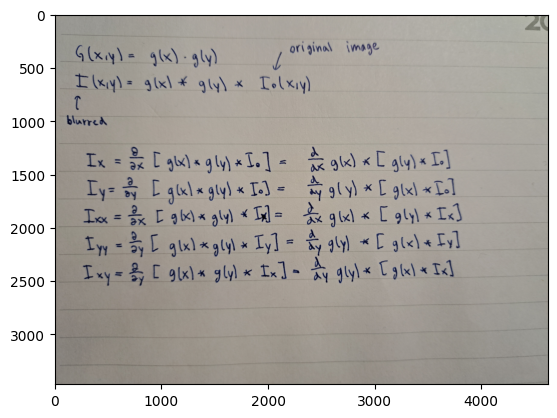

In [2]:
izpeljava = cv2.cvtColor(cv2.imread('images/izpeljava.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(izpeljava)

b)

In [3]:
def gauss(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
    g /= g.sum()
    return g.reshape((-1, 1)), x

In [4]:
def gaussdx(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = -1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
    g /= np.abs(g).sum()
    return g.reshape((-1, 1)), x

c)

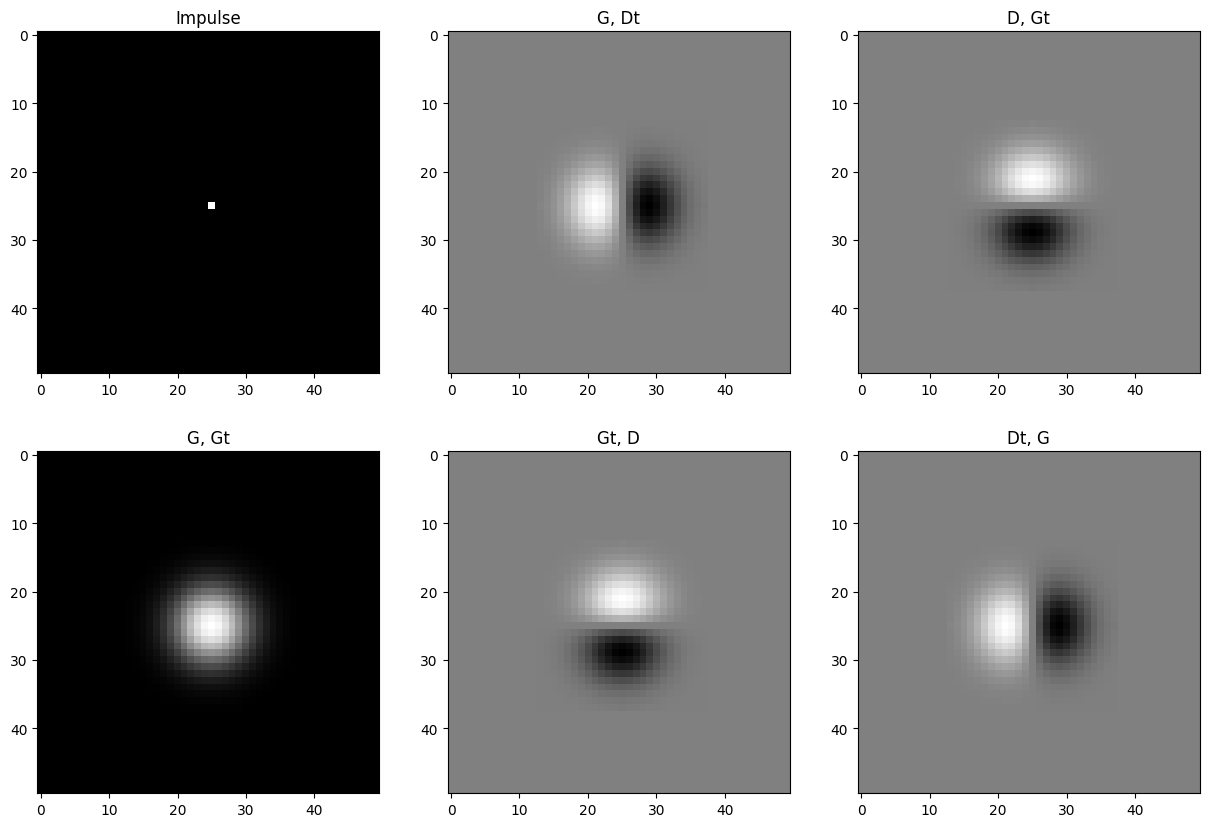

In [5]:
impulse = np.zeros((50,50))
impulse[25,25]=1

G, _ = gauss(4, 25)
DG, _ = gaussdx(4, 25)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1, title="Impulse")
plt.imshow(impulse, cmap='gray')
plt.subplot(2, 3, 2, title="G, Dt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, DG.T), cmap='gray')
plt.subplot(2, 3, 3, title="D, Gt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, DG), -1, G.T), cmap='gray')
plt.subplot(2, 3, 4, title="G, Gt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, G.T), cmap='gray')
plt.subplot(2, 3, 5, title="Gt, D")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G.T), -1, DG), cmap='gray')
plt.subplot(2, 3, 6, title="Dt, G")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, DG.T), -1, G), cmap='gray')

d)

In [6]:
def gradient_magnitude(I_x, I_y):
    mag = np.sqrt(I_x**2 + I_y**2)
    dir = np.arctan2(I_y, I_x)
    return mag, dir

(<Axes: title={'center': 'I_dir'}>,
 <matplotlib.image.AxesImage at 0x114cbad90>)

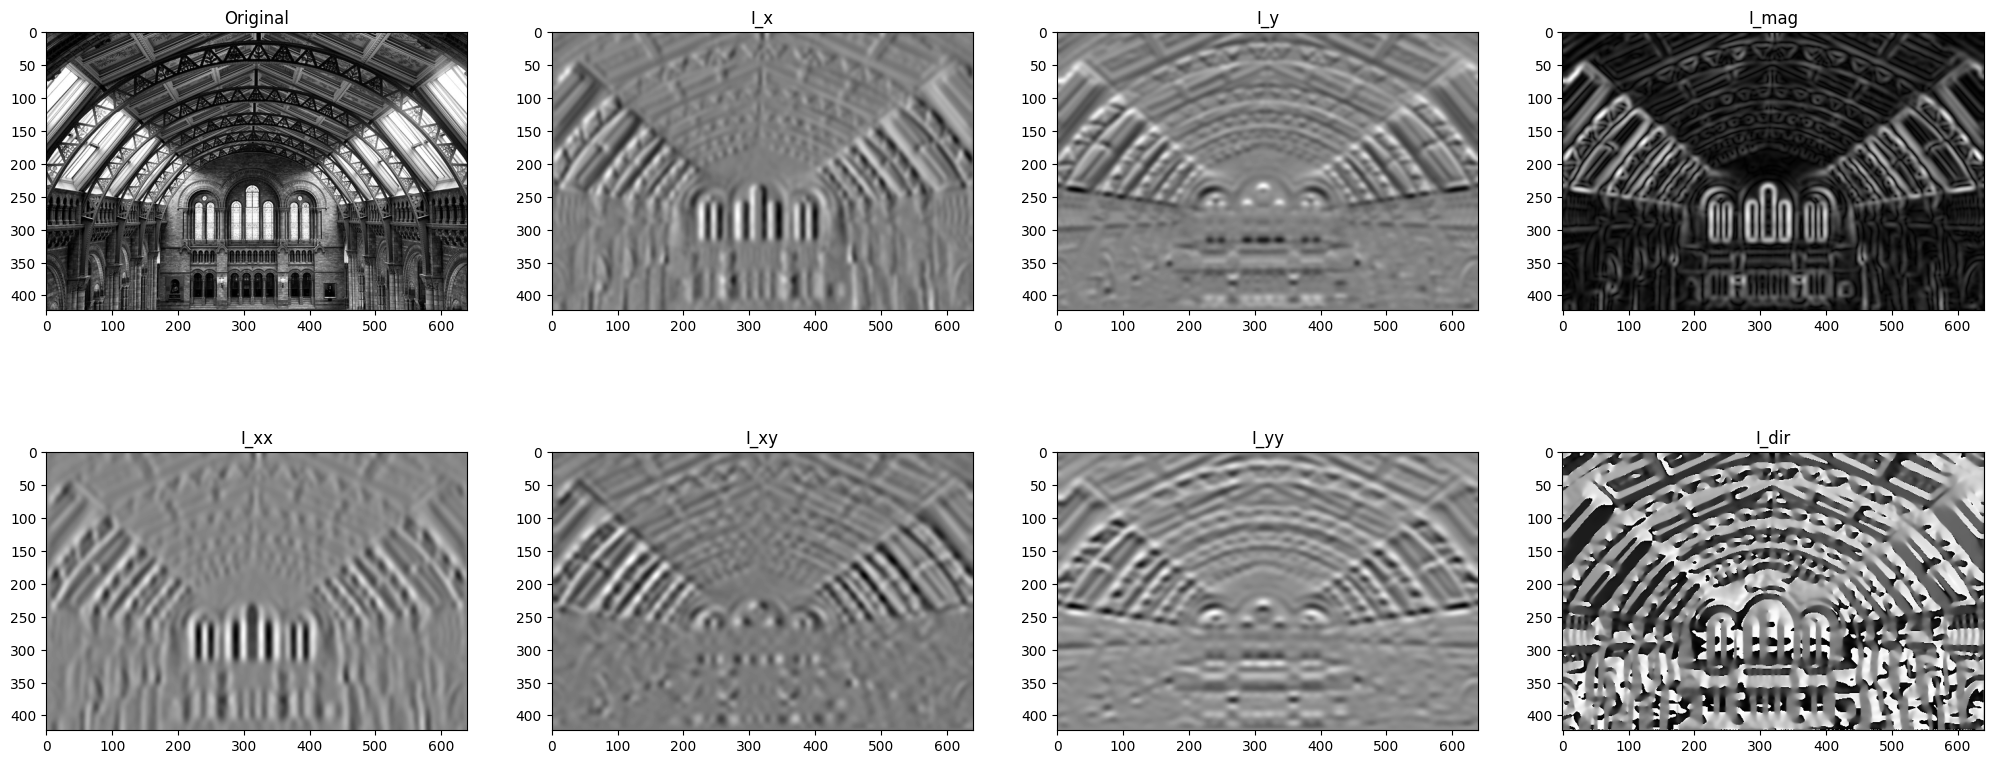

In [7]:
museum = cv2.cvtColor(cv2.imread('images/museum.jpg'), cv2.COLOR_BGR2RGB)
museum_gray = cv2.cvtColor(museum, cv2.COLOR_RGB2GRAY).astype('float64')

museum_x = cv2.filter2D(cv2.filter2D(museum_gray, -1, DG.T), -1, G)
museum_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, DG)
museum_xx = cv2.filter2D(cv2.filter2D(museum_x, -1, DG.T), -1, G)
museum_yy = cv2.filter2D(cv2.filter2D(museum_y, -1, G.T), -1, DG)
museum_xy = cv2.filter2D(cv2.filter2D(museum_x, -1, G.T), -1, DG)

museum_mag, museum_dir = gradient_magnitude(museum_x, museum_y)

plt.figure(figsize=(25, 10))
plt.subplot(2, 4, 1, title="Original")
plt.imshow(museum_gray, cmap='gray')
plt.subplot(2, 4, 2, title="I_x")
plt.imshow(museum_x, cmap='gray')
plt.subplot(2, 4, 3, title="I_y")
plt.imshow(museum_y, cmap='gray')
plt.subplot(2, 4, 4, title="I_mag")
plt.imshow(museum_mag, cmap='gray')
plt.subplot(2, 4, 5, title="I_xx"), plt.imshow(museum_xx, cmap='gray')
plt.subplot(2, 4, 6, title="I_xy"), plt.imshow(museum_xy, cmap='gray')
plt.subplot(2, 4, 7, title="I_yy"), plt.imshow(museum_yy, cmap='gray')
plt.subplot(2, 4, 8, title="I_dir"), plt.imshow(museum_dir, cmap='gray')

e)

In [8]:
def grad_hist(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float64')
    img_x = cv2.filter2D(cv2.filter2D(img_gray, -1, DG.T), -1, G)
    img_y = cv2.filter2D(cv2.filter2D(img_gray, -1, G.T), -1, DG)

    img_mag, img_dir = gradient_magnitude(img_x, img_y)
    histograms = np.array([np.zeros(8) for _ in range(64)])

    w, h = img_gray.shape

    for i in range(8):
        for j in range(8):
            for x in range(w):
                for y in range(h):
                    histograms[i + 8*j][round(np.pi / 8 * img_dir[x, y])] += img_mag[x, y]
    return histograms

In [9]:
def compare_histograms(H1, H2):
    return np.sqrt(np.sum((H1.flatten() - H2.flatten()) ** 2))

In [10]:
def calculate_histograms(path, H_i):
    histograms = []
    for item in os.listdir(path):
        image = cv2.cvtColor(cv2.imread(path + item), cv2.COLOR_BGR2RGB)
        H = grad_hist(image)
        d_L2 = compare_histograms(H, H_i)
        histograms.append((image, H, d_L2))
    return histograms

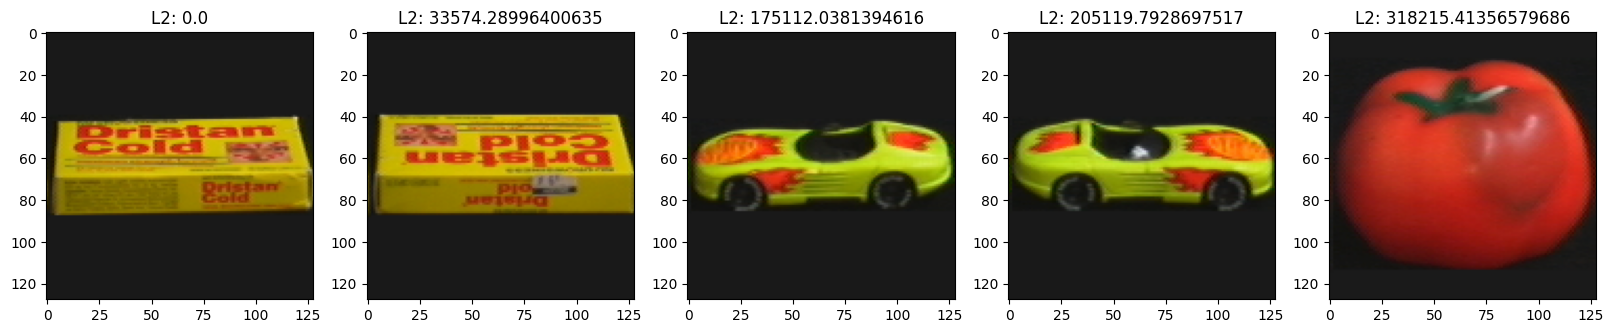

In [11]:
flask = cv2.cvtColor(cv2.imread('./dataset/object_01_1.png'), cv2.COLOR_BGR2RGB)
flask_hist = grad_hist(flask)

all_histograms = calculate_histograms("./dataset/", flask_hist)
hists_sorted = sorted(all_histograms, key = lambda hist: hist[2])

plt.figure(figsize=(20,7))
for i, (img, H, d) in enumerate(hists_sorted[:5]):
    plt.subplot(1, 5, i + 1, title=f"L2: {d}")
    plt.imshow(img)

# Exercise 2

a)

In [12]:
def findedges(I, sigma, theta):
    G, _ = gauss(sigma, 2*math.ceil(sigma*3)+1)
    D, _ = gaussdx(sigma, 2*math.ceil(sigma*3)+1)
    I_x= cv2.filter2D(cv2.filter2D(museum_gray, -1, D.T), -1, G)
    I_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, D)
    mag, _ = gradient_magnitude(I_x, I_y)
    I_e = np.where(mag > theta, 1, 0)
    return I_e

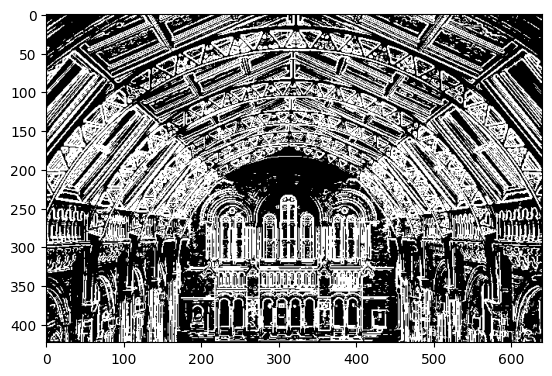

In [13]:
museum_edges = findedges(museum_gray, 1, 15)

plt.imshow(museum_edges, cmap='gray')

b)

In [14]:
def nonmaxima_suppression(img_mag, img_dir):
    res = img_mag.copy()

    # ignoring edges
    for y in range(1, img_mag.shape[0]-1):
        for x in range(1, img_mag.shape[1]-1):
            fi = img_dir[y,x] % np.pi
            
            # right
            if (0 <= fi and fi < np.pi/4):
                if img_mag[y,x] < img_mag[y, x-1] or img_mag[y,x] < img_mag[y, x+1]:
                    res[y,x] = 0
            # right up
            if (np.pi/4 <= fi and fi < np.pi/2):
                if img_mag[y,x] < img_mag[y-1, x-1] or img_mag[y,x] < img_mag[y+1, x+1]:
                    res[y,x] = 0
            # up
            if (np.pi/2 <= fi and fi < 3*np.pi/4):
                if img_mag[y,x] < img_mag[y-1, x] or img_mag[y,x] < img_mag[y+1, x]:
                    res[y,x] = 0
            # left up
            if (3*np.pi/4 <= fi and fi < np.pi):
                if img_mag[y,x] < img_mag[y+1, x-1] or img_mag[y,x] < img_mag[y-1, x+1]:
                    res[y,x] = 0
    return res

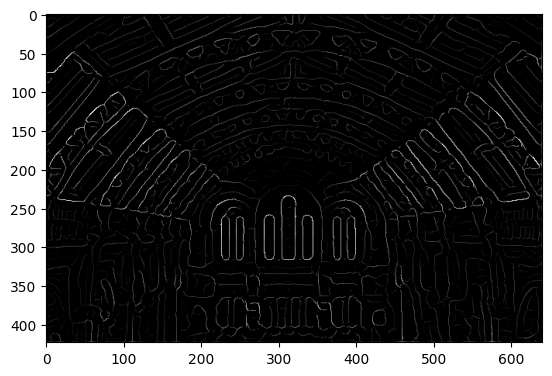

In [15]:
museum_suppressed = nonmaxima_suppression(museum_mag, museum_dir)

plt.imshow(museum_suppressed, cmap='gray')

c)

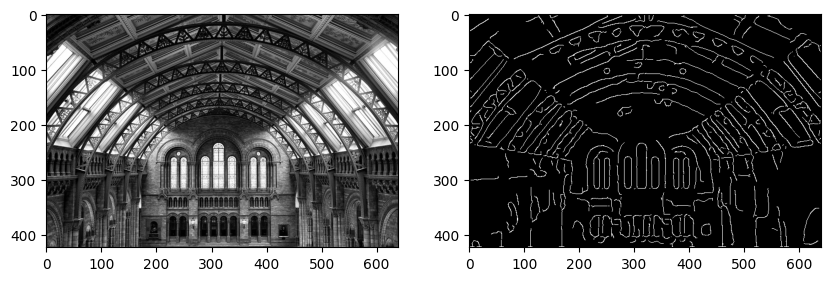

In [16]:
t_high = 25
t_low = 10

museum_low = np.where(museum_suppressed > t_low, 1, 0)
museum_high = np.where(museum_suppressed > t_high, 1, 0)

n, labels, _, _ = cv2.connectedComponentsWithStats(museum_low.astype('uint8'), connectivity=8)

result = np.zeros(museum_suppressed.shape)

for label in range(1, n):
    if np.any(museum_high[labels == label]):
        result[labels == label] = 1

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(museum_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')

# Exercise 3

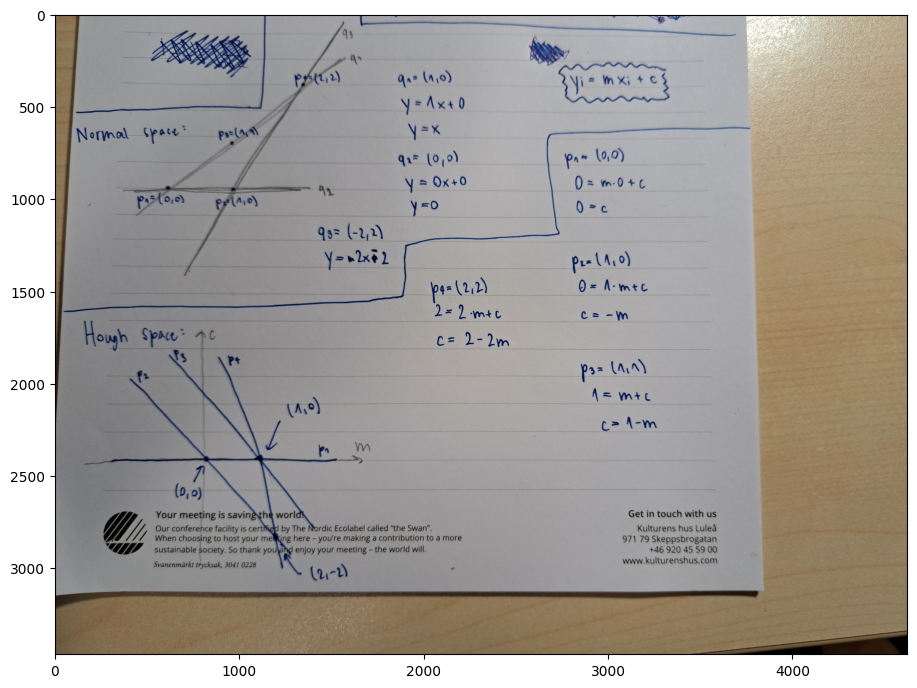

In [37]:
hough_rocno = cv2.cvtColor(cv2.imread('images/hough_rocno.jpg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(11,11))
plt.imshow(hough_rocno)

a)

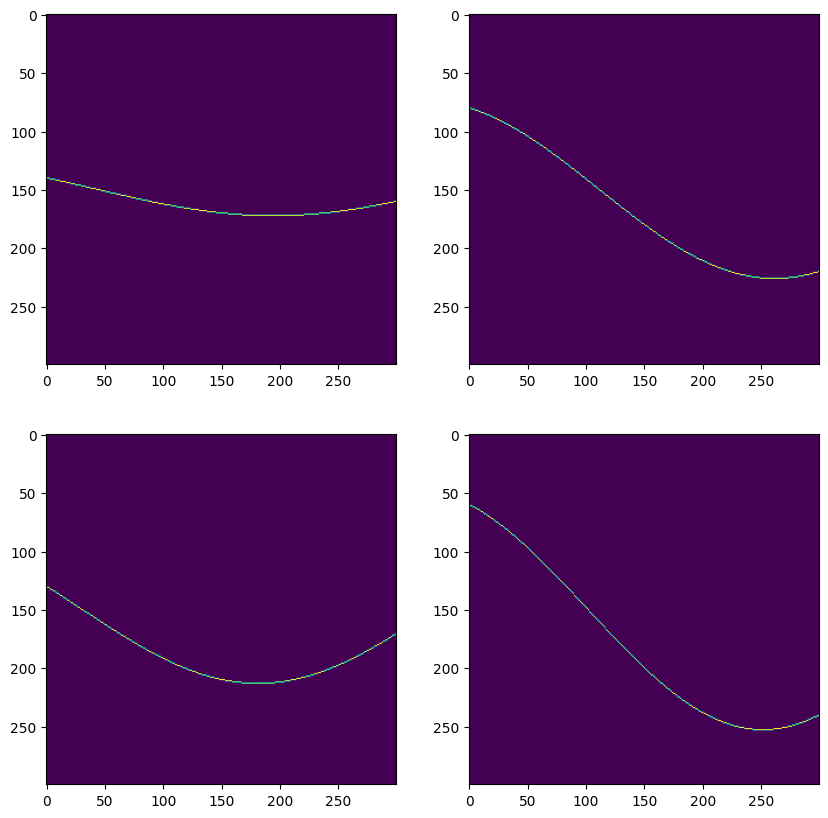

In [36]:
points = [(20, 10), (30, 70), (60, 20), (50, 90)]

plt.figure(figsize=(10, 10))
k = 1
for y, x in points:
    acc = np.zeros((300, 300))
    
    # we plot the sinusoid of a line over the range 300
    for i in range(300):
        # fi ranges [-pi/2, pi/2]
        theta = i/300 * np.pi - np.pi/2
        rho = y * np.cos(theta) + x * np.sin(theta)
        j = round(rho) + 150
        if j < 0 or j >= 300:
            continue
    
        acc[j][i]+=1

    plt.subplot(2, 2, k)
    plt.imshow(acc, cmap='viridis')
    
    k += 1

b)

In [19]:
def hough_find_lines(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins))
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x] >= 1:
                for i in range(theta_bins):
                    # theta goes [-pi/2, pi/2]
                    theta = i/theta_bins * np.pi - np.pi/2
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    # ro goes from [-D, D]
                    j = round((rho + D) / (2*D) * rho_bins)
                    if j < 0 or j >= rho_bins:
                        continue
                    acc[j][i] += 1
    return acc

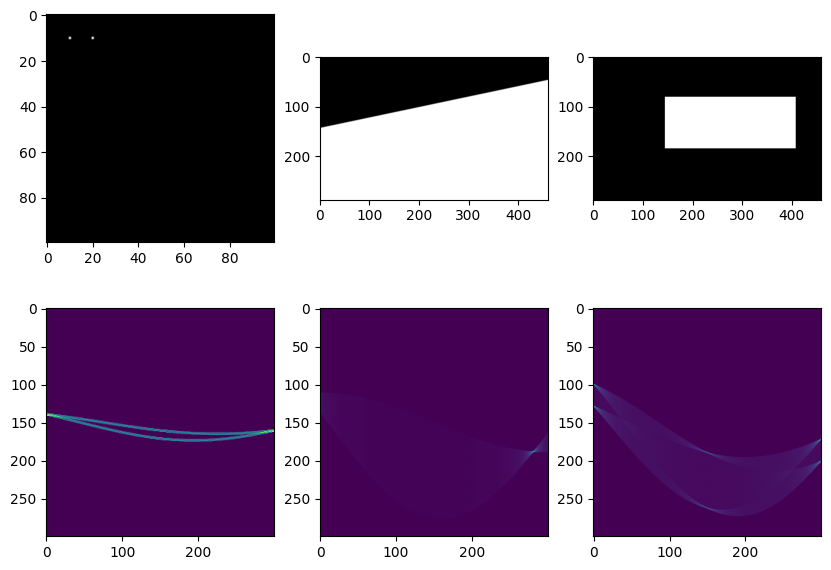

In [20]:
syntethic = np.zeros((100, 100)).astype('uint8')
syntethic[10, 10] = 255
syntethic[10, 20] = 255
oneline = cv2.cvtColor(cv2.imread('images/oneline.png'), cv2.COLOR_BGR2GRAY)
rectangle = cv2.cvtColor(cv2.imread('images/rectangle.png'), cv2.COLOR_BGR2GRAY)

syntethic_edges = cv2.Canny(syntethic, threshold1=100, threshold2=200)
rectangle_edges = cv2.Canny(rectangle, threshold1=100, threshold2=200)
oneline_edges = cv2.Canny(oneline, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 7))
plt.subplot(2, 3, 1)
plt.imshow(syntethic, cmap='gray')
plt.subplot(2, 3, 2)
plt.imshow(oneline, cmap='gray')
plt.subplot(2, 3, 3)
plt.imshow(rectangle, cmap='gray')

plt.subplot(2, 3, 4)
plt.imshow(hough_find_lines(syntethic_edges, 300, 300), cmap='viridis')
plt.subplot(2, 3, 5)
plt.imshow(hough_find_lines(oneline_edges, 300, 300), cmap='viridis')
plt.subplot(2, 3, 6)
plt.imshow(hough_find_lines(rectangle_edges, 300, 300), cmap='viridis')

c)

In [21]:
# suppresses pixels (lines) if they are not maxima of their neighbours
def nonmaxima_suppression_box(img):
    res = img.copy()
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            neighbourhood = [(x + i, y + j) for i in range(-1, 2) for j in range(-1, 2)]
            
            for x_n, y_n in neighbourhood:
                if x_n < 0 or y_n < 0 or x_n >= img.shape[0] or y_n >= img.shape[1]:
                    continue
                # suppress non-maximums
                if img[x, y] < img[x_n, y_n]:
                    res[x, y] = 0
    return res

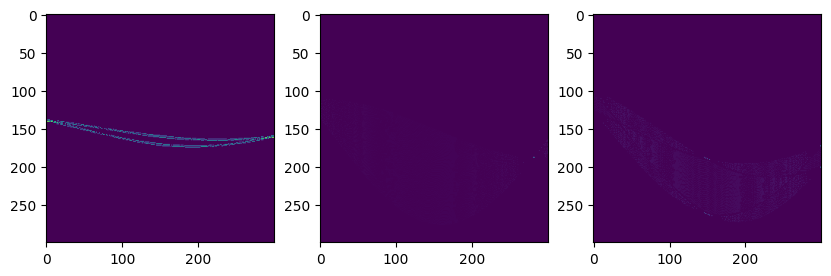

In [22]:
syntethic_suppressed = nonmaxima_suppression_box(hough_find_lines(syntethic_edges, 300, 300))
oneline_suppressed = nonmaxima_suppression_box(hough_find_lines(oneline_edges, 300, 300))
rectangle_suppressed = nonmaxima_suppression_box(hough_find_lines(rectangle_edges, 300, 300))

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(syntethic_suppressed, cmap='viridis')
plt.subplot(1, 3, 2)
plt.imshow(oneline_suppressed, cmap='viridis')
plt.subplot(1, 3, 3)
plt.imshow(rectangle_suppressed, cmap='viridis')

d)

In [23]:
def draw_image_with_lines(img, acc_bin):
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for j, i in np.argwhere(acc_bin):
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    plt.imshow(img, cmap='gray')

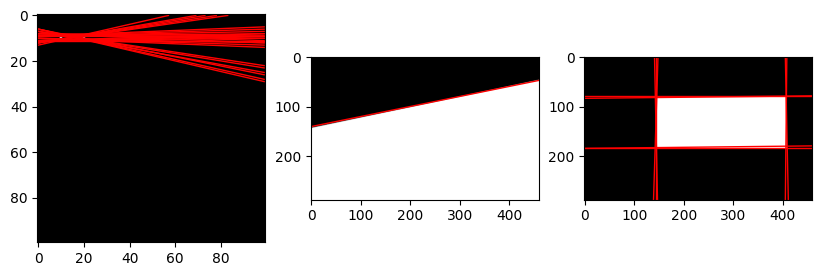

In [24]:
threshold1 = 6
threshold2 = 100
threshold3 = 100

syntethic_bin = np.where(syntethic_suppressed < threshold1, 0, 1)
oneline_bin = np.where(oneline_suppressed < threshold2, 0, 1)
rectangle_bin = np.where(rectangle_suppressed < threshold3, 0, 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
draw_image_with_lines(syntethic, syntethic_bin)
plt.subplot(1, 3, 2)
draw_image_with_lines(oneline, oneline_bin)
plt.subplot(1, 3, 3)
draw_image_with_lines(rectangle, rectangle_bin)

e)

theta is [-pi/2, pi/2]
rho is [-D, D]

In [25]:
def show_lines(img, subplot):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    img_edges = cv2.Canny(img_gray, 100, 200)    
    img_acc = hough_find_lines(img_edges, 300, 300)    
    
    plt.subplot(2, 2, subplot)
    plt.imshow(img_acc)

    img_acc_s = nonmaxima_suppression_box(img_acc)
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    N = 10
    acc_sorted = np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)

    plt.subplot(2, 2, subplot + 1)
    for k in range(N):
        j, i = acc_sorted[0][k], acc_sorted[1][k]
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    
    plt.imshow(img)

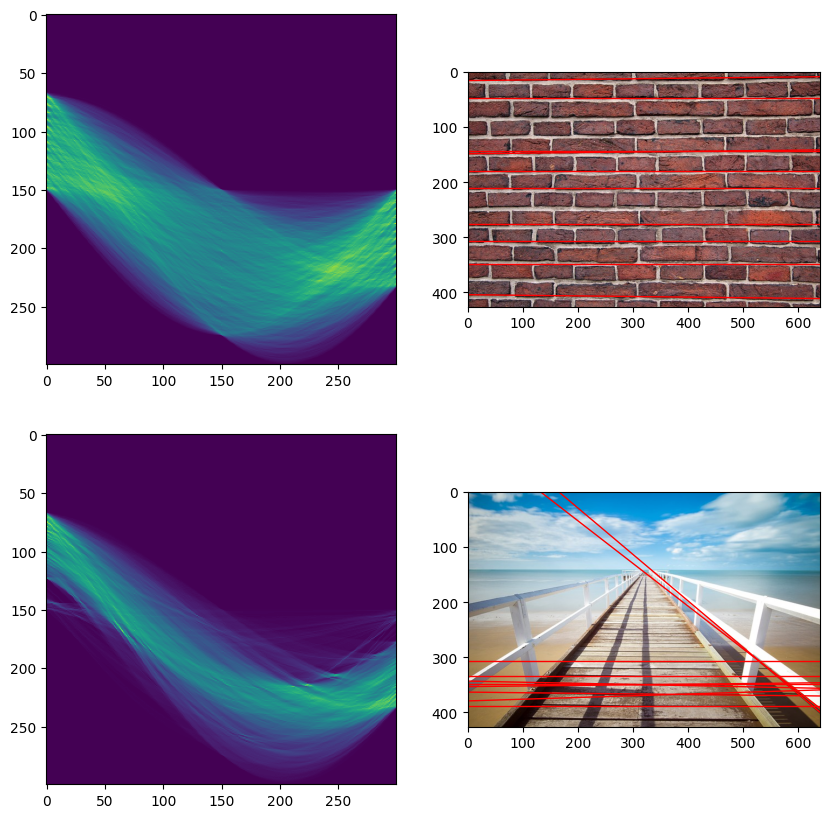

In [26]:
plt.figure(figsize=(10, 10))
bricks = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB)
show_lines(bricks, 1)

pier = cv2.cvtColor(cv2.imread('images/pier.jpg'), cv2.COLOR_BGR2RGB)
show_lines(pier, 3)

f)

In [27]:
def hough_improved(img_mag, img_dir, theta_bins, rho_bins):
    MAG_TRESH = 15
    img_bin = np.where(img_mag > MAG_TRESH, 1, 0)
    acc = np.zeros((rho_bins, theta_bins), dtype='int32')
    
    D = np.sqrt(img_mag.shape[0]**2 + img_mag.shape[1]**2)
    
    for x in range(img_bin.shape[1]):
        for y in range(img_bin.shape[0]):
            if img_bin[y, x] != 1:
                continue

            theta = (img_dir[y,x] + np.pi/2) % np.pi - np.pi/2
            rhos = y * np.sin(theta) + x * np.cos(theta)
            i = np.round((0.5 + (theta / np.pi)) * (theta_bins-1)).astype('int32')
            j = np.round((rhos + D) / (2*D) * (rho_bins)).astype('int32')

            if j < 0 or j >= rho_bins:
                continue

            acc[j, i] += 1
    return acc

In [28]:
def show_lines_improved(img, subplot):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # smaller sigma for better precision
    sigma = 0.7
    G, _ = gauss(sigma, 2*math.ceil(sigma*3)+1)
    D, _ = gaussdx(sigma, 2*math.ceil(sigma*3)+1)
    img_x = cv2.filter2D(cv2.filter2D(img_gray.astype('float64'), -1, D.T), -1, G)
    img_y = cv2.filter2D(cv2.filter2D(img_gray.astype('float64'), -1, G.T), -1, D)
    img_mag =  np.sqrt(img_x**2 + img_y**2)
    img_dir = np.arctan2(img_y, img_x)
    
    img_acc = hough_improved(img_mag, img_dir, 300, 300)
    img_acc_s = nonmaxima_suppression_box(img_acc)
    
    plt.subplot(2, 2, subplot)
    plt.imshow(img_acc)

    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)    
    N = 10
    acc_sorted = np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)

    plt.subplot(2, 2, subplot + 1)
    for k in range(N):
        j, i = acc_sorted[0][k], acc_sorted[1][k]
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    
    plt.imshow(img)

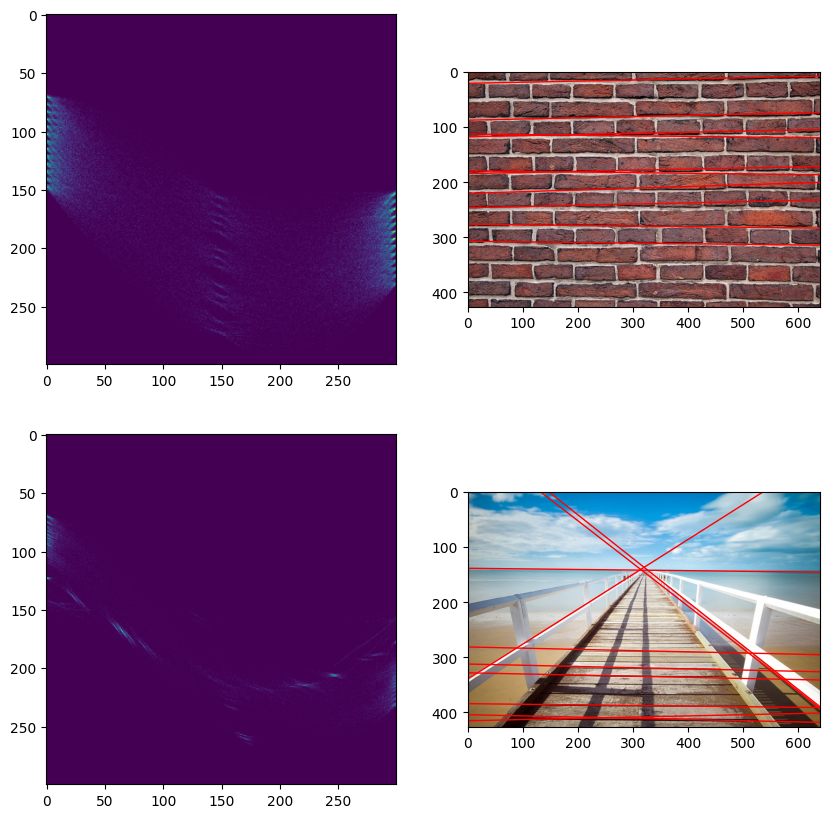

In [29]:
plt.figure(figsize=(10, 10))
bricks = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB)
show_lines_improved(bricks, 1)

pier = cv2.cvtColor(cv2.imread('images/pier.jpg'), cv2.COLOR_BGR2RGB)
show_lines_improved(pier, 3)

g)

for a's in a certain range we compute the accumulator using b = +-sqrt(r^2 - (x - a)^2) + y

In [30]:
def hough_circles(img, r):
    acc = np.zeros_like(img, dtype='int32')
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] < 1:
                continue
            
            for a in range(acc.shape[1]):
                det = r**2 - (x-a)**2
                if det < 0:
                    continue
                b1 = int(+ np.sqrt(det) + y)
                b2 = int(- np.sqrt(det) + y)
                
                if (0 <= b1) and (b1 < acc.shape[0]):            
                    acc[b1, a] += 1
                if (0 <= b2) and (b2 < acc.shape[0]):            
                    acc[b2, a] += 1
    return acc

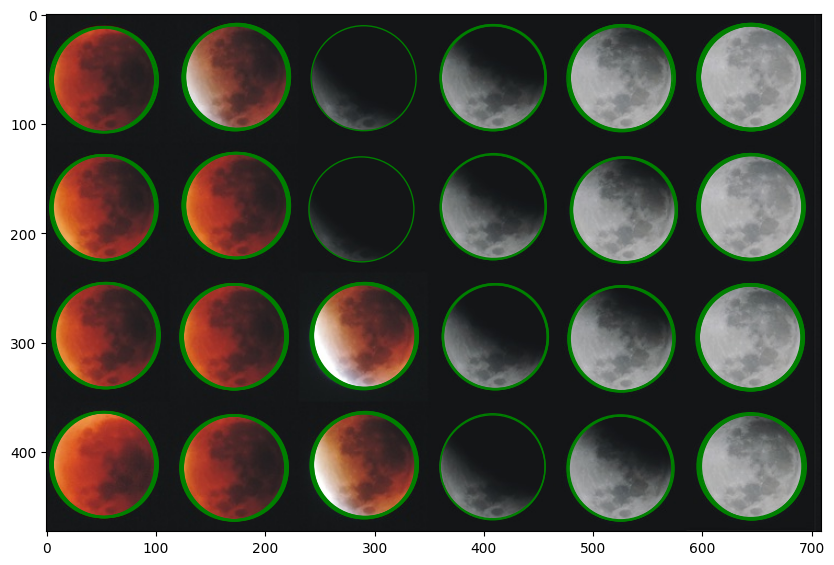

In [31]:
eclipse = cv2.cvtColor(cv2.imread('images/eclipse.jpg'), cv2.COLOR_BGR2RGB)

eclipse_gray = cv2.cvtColor(eclipse, cv2.COLOR_RGB2GRAY)
eclipse_edges = cv2.Canny(eclipse_gray, 100, 200)

acc = hough_circles(eclipse_edges, 48)
acc_s = nonmaxima_suppression_box(acc)

acc_b = np.where(acc > 50, 1, 0)

figure, ax = plt.subplots(figsize=(10, 10))
for y in range(acc_b.shape[1]):
        for x in range(acc_b.shape[0]):
            if acc_b[x, y] < 1:
                continue            
            circle = plt.Circle( (y,x), 48 , fill=False, color="green")
            ax.add_artist(circle)
plt.imshow(eclipse)

h)

line_equation: x*cos(theta) + y*sin(theta) = rho

we plug in x = 0, x = w, y = 0, y = h and factor out the other coordinate

In [32]:
def line_weight(rho, theta, w, h):
    intersect = []
    
    x = rho/np.cos(theta)
    if 0 <= x and x < w:
        intersect.append((x, 0))
    
    x = (rho - h*np.sin(theta))/np.cos(theta)
    if 0 <= x and x < w:
        intersect.append((x, h))
    
    y = rho/np.sin(theta)
    if 0 <= y and y < h:
        intersect.append((0, y))
    
    y = (rho - w*np.cos(theta))/np.sin(theta)
    if 0 <= y and y < h:
        intersect.append((w, y))
    
    if len(intersect) != 2:
        return 0
    length = np.sqrt((intersect[0][0] - intersect[1][0])**2 + (intersect[0][1] - intersect[1][1])**2)
    
    if length == 0:
        return 0
    
    return 1/length

In [33]:
def hough_weighted(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins), dtype=np.float64)
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] >= 1:
                for i in range(theta_bins):
                    # theta in [-pi/2, pi/2]
                    theta = i/theta_bins * np.pi - np.pi/2
                    rho = x * np.cos(theta) + y * np.sin(theta)

                    j = round((rho + D) / (2*D) * rho_bins)
                    if j < 0 or j >= rho_bins:
                        continue
                    
                    acc[j][i] += line_weight(rho, theta, img.shape[1], img.shape[0])
    return acc

In [34]:
def show_lines_weighted(img, subplot):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 200)
    
    img_acc = hough_weighted(img_edges, 300, 300)
    img_acc_s = nonmaxima_suppression_box(img_acc)
    
    plt.subplot(2, 2, subplot)
    plt.imshow(img_acc_s)

    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)    
    N = 10
    acc_sorted = np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)

    plt.subplot(2, 2, subplot + 1)
    for k in range(N):
        j, i = acc_sorted[0][k], acc_sorted[1][k]
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    
    plt.imshow(img)

/var/folders/cr/14yjwnk14zdcpjclx10yprwc0000gp/T/ipykernel_17684/467710334.py:12: RuntimeWarning: invalid value encountered in scalar divide
  y = rho/np.sin(theta)
/var/folders/cr/14yjwnk14zdcpjclx10yprwc0000gp/T/ipykernel_17684/467710334.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  y = (rho - w*np.cos(theta))/np.sin(theta)
/var/folders/cr/14yjwnk14zdcpjclx10yprwc0000gp/T/ipykernel_17684/467710334.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  y = rho/np.sin(theta)


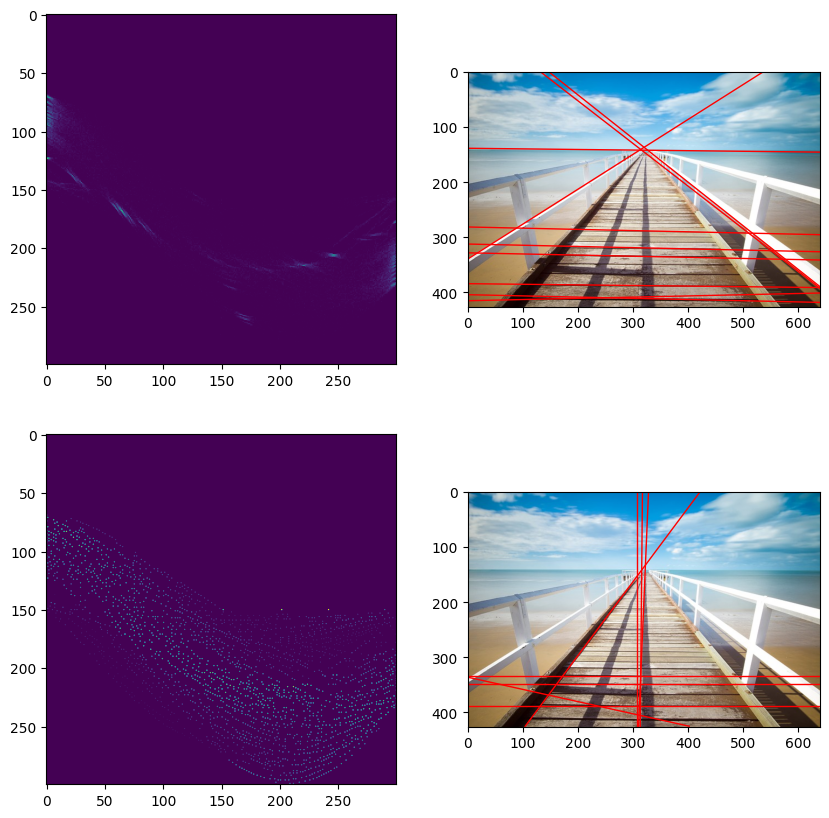

In [35]:
plt.figure(figsize=(10, 10))
pier = cv2.cvtColor(cv2.imread('images/pier.jpg'), cv2.COLOR_BGR2RGB)
show_lines_improved(pier, 1)

show_lines_weighted(pier, 3)